# Project 2

## Assignment 1: Golf ball
### Initial setup

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

### Problem formulation

After launch forces acting on the ball are: drag force, lift force, gravitational force. The forces are drawn with respect to their direction and equations for x and y axes could be set up:
$$
X: -\sin(\frac{\pi}{2} - \theta)\cdot F_D - \sin(\theta)\cdot F_L = m\cdot a_x
$$

$$
Y: -mg + \cos\theta \cdot F_L - \cos(\frac{\pi}{2} - \theta)\cdot F_D = m\cdot a_y
$$
This could be further simplified and recalling that acceleration is a second time derivative of the coordinate the equations take a following look:
$$
X: m \frac{\partial^2 x}{\partial t^2} = -\alpha_D (\frac{\partial x}{\partial t})^2\cos(\theta) - \alpha_L(\frac{\partial x}{\partial t})^2\sin(\theta)
$$

$$
Y: m \frac{\partial^2 y}{\partial t^2} = -\alpha_D (\frac{\partial y}{\partial t})^2\sin(\theta) + \alpha_L(\frac{\partial y}{\partial t})^2\cos(\theta) - mg
$$
The system of equations is non-linear and can be solved numerically. With initial conditions given:
x(0) = y(0) = 0, $\dot{x}(0) = v_0\cos(\theta_0)$ and $\dot{y}(0) = v_0\sin(\theta_0)$

### Differential equation solution

In [5]:
def drag_force(vx, vy, alphaD):
  """
  Function calculates the drag force for x and y dimensions. The value depends on coefficient alpha as well as squared velocity.
  """
  velocity = np.array([vx, vy])
  velocity_norm = np.linalg.norm(velocity, axis=0)
  velocity_direction = velocity / velocity_norm
  force_direction = - velocity_direction
  F = alphaD * velocity_norm**2 * force_direction

  F_x, F_y = F[0], F[1]
  return (F_x, F_y)

def lift_force(vx, vy, alphaL):
  """
  Function calculates the lift force for x and y dimensions. The value depends on coefficient alpha as well as squared velocity.
  """
  velocity = np.array([vx,vy])
  velocity_norm = np.linalg.norm(velocity, axis=0)
  velocity_direction = velocity/ velocity_norm
  rotation_matrix = np.array([[0, -1],[1, 0]])
  force_direction = np.dot(rotation_matrix, velocity_direction)
  F = alphaL * velocity_norm**2 * force_direction

  F_x, F_y = F[0], F[1]
  
  return (F_x, F_y)

def gravitational_force(m, g=9.81):
  """
  Function calculates the value of gravitational force acting on a golf ball with mass m. 
  """
  return m*g


In [6]:
def derivatives(vec, t, alphaD, alphaL, m, situation):
  """
  The function calculates the derivatives for various scenarios: model of the ball's
  motion with 1) all forces taken into account, 2) no lift but with drag, 3) no drag
  but with lift, 4) with no resisting forces at all. The function takes mass of the ball,
  coefficients of drag and lift as well as initial conditions included
  in parameter "vec". 
  """
  x, y, dxdt, dydt = vec

  if situation.lower() == "all forces":
    d2xdt2 = (1/m) * (drag_force(dxdt, dydt, alphaD)[0] + lift_force(dxdt, dydt, alphaL)[0])
    d2ydt2 = (1/m) * (drag_force(dxdt, dydt, alphaD)[1] + lift_force(dxdt, dydt, alphaL)[1] - gravitational_force(m))
  elif situation.lower() == "no lift":
    d2xdt2 = (1/m) * (drag_force(dxdt, dydt, alphaD)[0])
    d2ydt2 = (1/m) * (drag_force(dxdt, dydt, alphaD)[1] - gravitational_force(m))
  elif situation.lower() == "no drag":
    d2xdt2 = (1/m) * (lift_force(dxdt, dydt, alphaL)[0])
    d2ydt2 = (1/m) * (lift_force(dxdt, dydt, alphaL)[1] - gravitational_force(m))
  elif situation.lower() == "no forces":
    d2xdt2 = 0
    d2ydt2 = (1/m) * (- gravitational_force(m))

  return (dxdt, dydt, d2xdt2, d2ydt2)


In [7]:
def alphaL_alphaD(r, rho, m, CL, CD):
  """
  Return alphaL and alphaD given the radius of the ball, the density of air, the mass of the ball,
  the lift cofficient and the drag coefficient.
  """
  alphaL = 1/2 * CL * rho * np.pi * r**2
  alphaD = 1/2 * CD * rho * np.pi * r**2
  return alphaL, alphaD

def motion_ball(theta, timelist, situation, CD=0.3, CL=0.3):
  """
  The function solves the second order differential equation of the position of 
  the ball. Returns 4 arrays with discrete values of x, y, vx, vy. Takes as a parameters 
  launch angle theta, timelist as the amount of discrete intervals for numerical calculations
  and situation parameter for derivatives function to set the forces acknowledged.
  """
  r = 0.02
  rho = 1.20429
  m = 0.05

  alphaL, alphaD = alphaL_alphaD(r, rho, m, CD, CL)
  v0 = 60

  inivec = (0 , 0, v0*np.cos(theta), v0*np.sin(theta))

  #odeint method of scipy library that makes numerical calculations
  result = odeint(derivatives, inivec, timelist, args=(alphaD, alphaL, m, situation)) 
  return result


### Validation
In order to validate the result, we plot the y component of the forces (drag, lift and total) over the x position. In the same plot we display the y component of the velocity as a reference for understanding the result.

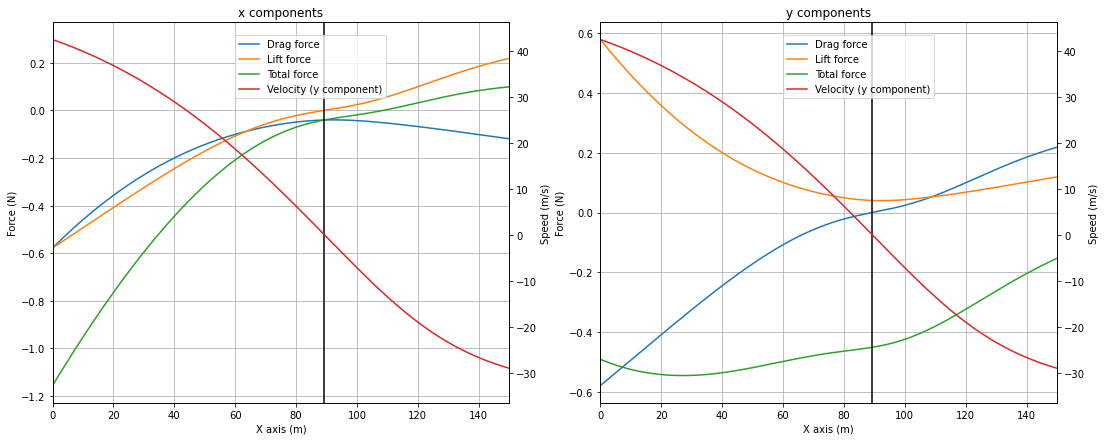

In [8]:
v0 = 60
time_interval = np.linspace(0,14,1000)
alphaL, alphaD = alphaL_alphaD(0.02, 1.20429, 0.05, 0.3, 0.3)

fig = plt.figure(figsize=(18,7))
ax1, ax3 = fig.subplots(1,2)
ax2, ax4 = ax1.twinx(), ax3.twinx()

c = motion_ball(np.pi/4, time_interval, "all forces")

Flx, Fly = lift_force(c[:,2], c[:,3], alphaL)
Fdx, Fdy = drag_force(c[:,2], c[:,3], alphaD)

def plot_forces(ax1, ax2, Fl, Fd, component):
  if component == 'x':
    Fg = 0
  elif component == 'y':
    Fg = - 0.05 * 9.81
  lns1 = ax1.plot(c[:,0], Fd, label='Drag force', color='tab:blue')
  lns2 = ax1.plot(c[:,0], Fl, label = "Lift force", color='tab:orange')
  lns3 = ax1.plot(c[:,0], Fg * np.ones(c.shape[0]) + Fl + Fd, label="Total force", color='tab:green')
  lns4 = ax2.plot(c[:,0], c[:,3], label="Velocity (y component)", color='tab:red')

  lns = lns1+lns2+lns3+lns4
  labs = [l.get_label() for l in lns]
  ax1.legend(lns, labs, loc=(0.4, 0.8))

  ax1.set_xlim(0, 150)
  ax1.set_xlabel('X axis (m)')
  ax1.set_ylabel('Force (N)')
  ax2.set_ylabel('Speed (m/s)')
  ax1.grid(True)
  ax1.set_title('{} components'.format(component))

  peak = np.abs(c[:, 3]).argmin()
  x_peak = c[peak,0]
  ax1.axvline(x_peak, color='black')

plot_forces(ax1, ax2, Flx, Fdx, 'x')
plot_forces(ax3, ax4, Fly, Fdy, 'y')

The black line in the plots indicates the position of the peak ($x_p$) of the trajectory, corresponding to the point where $v_y = 0$.

From the first plot we can verify that whereas the drag force is always negative (pointing left) the lift force changes sign at $x_p$. It is interesting to notice that, after a certain point, the total force is positive. This means that the lift overcome the drag at the end of the motion of the ball.

From the second plot we can see that the drag force changes its sign after the peak, whereas the lift is always positive. On the other hand the total force is always negative, so the lift and the drag y components never overcome the gravity.

Everything is consistent with the expectations.

### Analysis

The trajectories of the golf ball are depicted for different situations. The following graph shows the trajectories of the ball for various angles from $0^{o}$ to $90^{o}$ in situation, where all of the forces are taken into account. During the second graph set up, the distance in x direction the ball would travel is determined, as well as the time it takes to fly until it hits the ground. The way of determination is explained in comment next to the code.


For angle = 0 the time it takes to hit the ground = 3.49 s, the distcance the ball will travel will be = 146.08 m
For angle = 15 the time it takes to hit the ground = 6.67 s, the distcance the ball will travel will be = 206.58 m
For angle = 30 the time it takes to hit the ground = 8.23 s, the distcance the ball will travel will be = 197.82 m
For angle = 45 the time it takes to hit the ground = 9.11 s, the distcance the ball will travel will be = 156.06 m
For angle = 60 the time it takes to hit the ground = 9.46 s, the distcance the ball will travel will be = 87.66 m
For angle = 75 the time it takes to hit the ground = 9.32 s, the distcance the ball will travel will be = 2.24 m
For angle = 90 the time it takes to hit the ground = 8.56 s, the distcance the ball will travel will be = -73.69 m
The distance the ball travelled with neither drag and lift forces acting on it is 366.85m


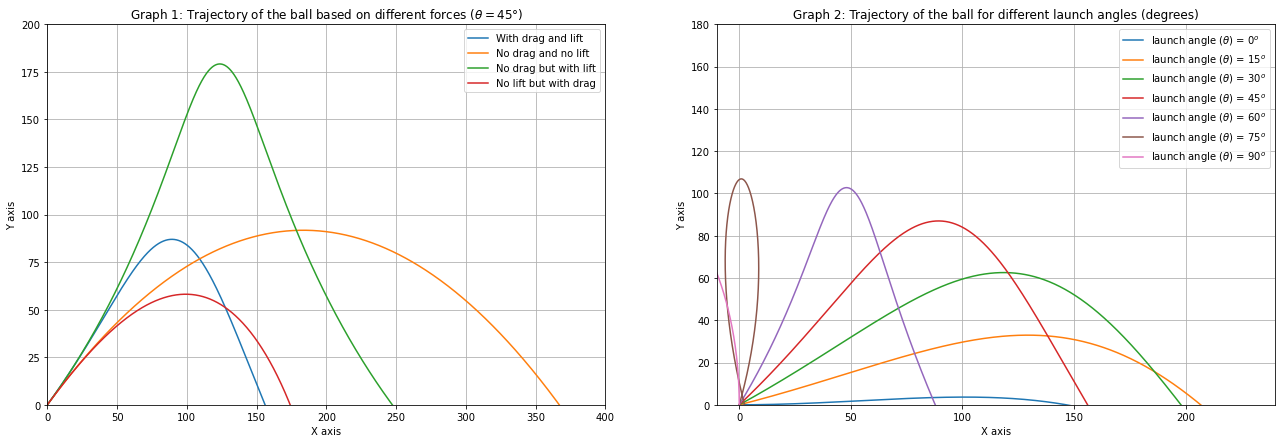

In [9]:
fig = plt.figure(figsize=(22,7))
time_interval = np.linspace(0,14,1000)

#first graph
ax1 = fig.add_subplot(1,2,1)
c1 = motion_ball(np.pi/4, time_interval, "all forces")
ax1.plot(c1[:,0], c1[:,1], label = "With drag and lift") #plots x vs y
ax1.grid(True)
ax1.set_xlabel("X axis")
ax1.set_ylabel("Y axis")
ax1.set_ylim(0, 200)
ax1.set_xlim(0, 400)
ax1.set_title(r"Graph 1: Trajectory of the ball based on different forces ($\theta = 45°$)")

c2 = motion_ball(np.pi/4, time_interval, "no forces")
ax1.plot(c2[:,0], c2[:,1], label = "No drag and no lift")

#Calculating numerically the distance the ball travelled for a linear case (no drag and no lift included) 
for j in c2[:,1]:                                                                                 
  if j < 0:                                                                                       
    position = np.where(j == c2)           
    distance = c2[position[0]-1,0]
    distance_for_accuracy = round(float(distance),2)                            # the value of distance that will be used to determine the accuracy                                                           
    break

c3 = motion_ball(np.pi/4, time_interval, "no drag")
ax1.plot(c3[:,0], c3[:,1], label = "No drag but with lift")

c4 = motion_ball(np.pi/4, time_interval, "no lift")
ax1.plot(c4[:,0], c4[:,1], label = "No lift but with drag")

#second graph
ax2 = fig.add_subplot(1,2,2)
ax2.set_ylim(0,180)
ax2.set_xlim(-10,240)
ax2.set_title("Graph 2: Trajectory of the ball for different launch angles (degrees)")
ax2.grid(True)
ax2.set_xlabel("X axis")
ax2.set_ylabel("Y axis")

angles = [0, np.pi/12, np.pi/6, np.pi/4, np.pi/3, 5*np.pi/12, np.pi/2]                              #set of angles to see the pattern

for i in angles:
  c = motion_ball(i, time_interval, "all forces")
  ax2.plot(c[:,0], c[:,1], label = r"launch angle ($\theta$) = {}$^o$".format(round(np.degrees(i))))

  #Determination of time and distance the ball would travel for different angles.

  for j in c[:,1]:                                                                                  #The time and distance are determined in the following way: We loop through the
    if j < 0:                                                                                       #array which contains the values for y coordinate and search for the first value
      position = np.where(j == c)                                                                   #which is negative (y<0). This means that the coordinate before this value was 
      time = time_interval[position[0]-1]                                                           #positive and it hits the ground between these two values. We find the position 
      distance = c[position[0]-1,0]                                                                 #of this value in y array and determine x and t values in their arrays at the
                                                                                                    #corresponding position. After it we break to change for the next angle.

      print(f"For angle = {round(np.degrees(i))} the time it takes to hit the ground = {round(float(time),2)} s, the distcance the ball will travel will be = {round(float(distance),2)} m")
      break
  
print(f"The distance the ball travelled with neither drag and lift forces acting on it is {distance_for_accuracy}m")
ax1.legend()
ax2.legend()
plt.show()

*The further discussion is for $\theta = \frac{\pi}{4}$ until the other angles are specified.*
 

>

To find out the accuracy of our calculations they should be compared to analytical calculations. The only case when we will be able to do this is when the case is linear. In our case it would be situation 2 (yellow line on graph 1.) where drag and lift forces are not included. The analytical calculations can be seen on the Picture 2., where $\alpha = \frac{\pi}{4}, v_0 = 60m/s, g = 9.81$ and $t$ is the time it takes to hit the ground. Whereas the numerical calculations return the value $366.85 m \implies \Delta d = 367.75 - 366.85 = 0.9 m$, with an accuracy $\Delta d / d = 0.24 \%$.


Moreover, it can be seen on the graph 1. that for the blue line (realistic scenario) the effect of damping due to additional forces takes place. After its peak the curve curls more than previously. The second part of the traveling path after the peak is less than the first one since $v_x$ decreases during the flight because of the drag force. The distance the ball travels without the drag and lift forces is much bigger than the distance traveled when these forces are taken into account, which is a result of resisting forces. Furthermore, the green line representing case when the lift is included but drag isn't can make since for such a light ball, whose weight is only 50 g. It can be seen that amplitude increases due to the lift effect. The different behavior occurs when lift is not included but the drag is. The amplitude of this trajectory (red line) is the lowest, which also makes sense as the main force acting upwards is not accounted. The drag may as well be seen as a damping of the curve

From graph 2 it can be inferred that the best launch angle theta lies somewhere between $0°$ and $45°$. The loop between these angles is now set up to determine the best angle. We use the same principle as in the code before to determine the time and distance it travels.

The best angle is 19.0. With this launch angle the golf ball will travel distance d = 208.29 m


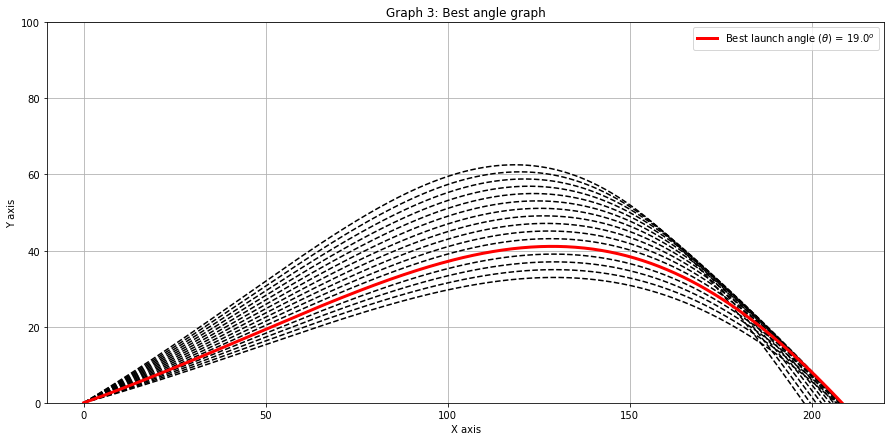

In [10]:
loop = np.linspace(15, 30, 16)
distance_loop = {}

fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1,1,1)
ax1.grid()
ax1.set_ylim(0, 100)
ax1.set_xlim(-10,220)
ax1.set_xlabel("X axis")
ax1.set_ylabel("Y axis")

for i in loop:                                                                  #loop through the angles
  m = motion_ball(np.radians(i), time_interval, "all forces")
  ax1.plot(m[:,0], m[:,1], linestyle = "dashed", color = "k")
  for j in m[:,1]:                                                              #loop through the values of y coordinate array                     
    if j < 0:                                                                                       
      position = np.where(j == m)           
      distance = m[position[0]-1,0]
      distance_loop[f"{i}"] = round(float(distance),2)                                                                     
      break

maximum_distance = max(distance_loop.values())                                  
best_angle = 0
for key, value in distance_loop.items():                                        #loop through dictionary "distance_loop" to find out the best angle to reach the furthest distance 
  if value == maximum_distance:
    best_angle = round(float(key),2)

m = motion_ball(np.radians(best_angle), time_interval, "all forces")
ax1.plot(m[:,0], m[:,1], label = r"Best launch angle ($\theta$) = {}$^o$".format(best_angle), linewidth = 3,color = "r")
ax1.set_title("Graph 3: Best angle graph")
print("The best angle is {}. With this launch angle the golf ball will travel distance d = {} m".format(best_angle, maximum_distance))
ax1.legend()
plt.show()